Let's train a simple deep-Q RL agent on a simple chemical engineering problem "PFR or CSTR" - 
see report PDF for specification of this problem

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML, Image

from scipy import integrate
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers import Adam
from keras.models import load_model

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

import time

%load_ext autoreload

Using TensorFlow backend.
c:\users\meatrobot\miniconda3\envs\rl2019\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\meatrobot\miniconda3\envs\rl2019\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\meatrobot\miniconda3\envs\rl2019\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\meatrobot\miniconda3

In [2]:
from PFRorCSTR import simulator # this is the RL environment

In [3]:
env = simulator(volume = 0.8, n_reactors=4)
nb_actions = env.action_space.n
env.observation_space.shape, env.action_space.n, 

((1,), 2)

In [4]:
%autoreload

# Let's look at the ideal solution

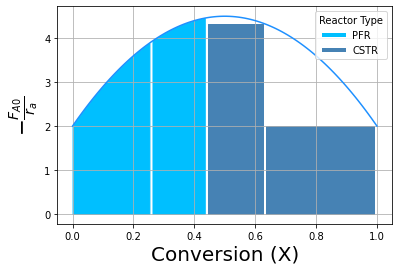

In [5]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
plt.plot(X, Y, color = "dodgerblue")
plt.xlabel("Conversion (X)", fontsize=label_size)
plt.ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
plt.grid(True)

previous_index = 0
conversion = 0
X_out_PFR = []
X_out_CSTR = []
X_react = []
Y_react = []
color = []

while conversion < 0.4:
    conversion = env.equation_solver(1, conversion)
    X_out_PFR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(Y[previous_index:index])
    previous_index = index
    color.append("deepskyblue")
  
while conversion > 0.4 and conversion <= 0.9:
    conversion = env.equation_solver(0, conversion)
    X_out_CSTR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(np.zeros(X_react[-1].shape) + Y[index])
    previous_index = index
    color.append("steelblue")



for i in range(len(X_react)):
    plt.fill_between(X_react[i], Y_react[i], color = color[i])

    
legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='PFR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='CSTR')] 

plt.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
plt.savefig('Ideal_Soln.png', bbox_inches='tight')

## Doube check volumes are correct to make sure simulator solver is working

In [6]:
def PFR(x):
    return -10*x**2 + 10*x + 2
def CSTR_vol(x, x_in):
    return (-10*x**2 + 10*x + 2)*(x - x_in)

PFR1 = integrate.quad(PFR, 0,  X_out_PFR[0])[0]
PFR2 = integrate.quad(PFR, X_out_PFR[0], X_out_PFR[1] )
CSTR1 = CSTR_vol(X_out_CSTR[0], X_out_PFR[-1])


PFR1, PFR2, CSTR1

(0.7999999999999999,
 (0.8000000000000004, 8.881784197001257e-15),
 0.8000000000000009)

In [7]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
steps = 15000
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [9]:
# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
hist = dqn.fit(env, nb_steps=steps)

Training for 15000 steps ...
Interval 1 (0 steps performed)

    1/10000 [..............................] - ETA: 14:07 - reward: 0.2601

c:\users\meatrobot\miniconda3\envs\rl2019\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 75s 7ms/step - reward: 0.2175
2500 episodes - episode_reward: 0.870 [0.769, 1.000] - loss: 0.000 - mae: 0.263 - mean_q: 0.534 - mean_eps: 0.683

Interval 2 (10000 steps performed)
 4996/10000 [=============>................] - ETA: 37s - reward: 0.2381done, took 112.615 seconds


# A variety of visualisations of the solution found by the agent are given below

In [10]:
reward_data = np.array(hist.history["episode_reward"])

In [11]:
np.savetxt("rewards.csv", reward_data, delimiter=",")

In [12]:
reward_data = np.loadtxt("rewards.csv", delimiter = ",")

In [13]:
model.save("DQN_agent.h5")

In [14]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [15]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

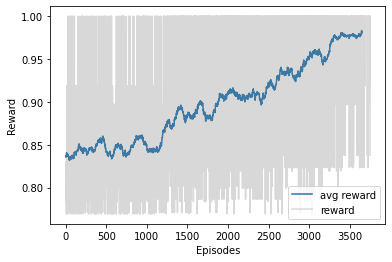

In [16]:
smoothed_rews = running_mean(reward_data, 100)
plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]),reward_data,color='grey', alpha=0.3)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"], loc=4)
plt.savefig('Learning.png', bbox_inches='tight')

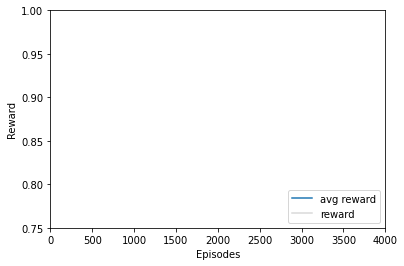

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward")
ax.set_xlim(0,4000)
ax.set_ylim(0.75, 1)
interval = 30

lines = []
line1, = ax.plot([], [])
lines.append(line1)
line2, = ax.plot([], [],color='grey', alpha=0.3)
lines.append(line2)
ax.legend(["avg reward", "reward"], loc=4 )

In [18]:
def init():
    for line in lines:
        line.set_data([],[])
    return lines

In [19]:
def anim(i):
    smoothed_rews_ = smoothed_rews[0:i*interval]
    reward_data_ = reward_data[0:i*interval]
    lines[0].set_data(np.arange(np.shape(smoothed_rews_)[0])[-len(smoothed_rews_):], smoothed_rews_)
    lines[1].set_data(np.arange(np.shape(reward_data_)[0]),reward_data_)
    return lines

In [20]:
anim_Learn = animation.FuncAnimation(fig, anim, frames = round(len(smoothed_rews)/interval), init_func=init, interval = 100, blit = True)

In [21]:
rc('animation', html='html5')
anim_Learn

In [22]:
anim_Learn.save('Learning.gif', writer='imagemagick', fps = 10)
Image(url='c.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


In [23]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'))
anim_Learn.save("Learning.mp4", writer = writer)
HTML(anim_Learn.to_html5_video())

In [24]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
choice(1) - conversions: [0, 0.2601494936395941], reactors: [1]
choice(2) - conversions: [0, 0.2601494936395941, 0.44804425979999357], reactors: [1, 1]
choice(3) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981], reactors: [1, 1, 0]
choice(4) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1], reactors: [1, 1, 0, 0]
Episode 1: reward: 1.000, steps: 4


In [25]:
env.reactor_seq, env.X

([1, 1, 0, 0],
 [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1])

In [26]:
y = [] 
x = []
CSTR = []
PFR = []
for i in range(0, 100):
    x.append(i/140)
    CSTR.append(env.equation_solver(0, x[i]))
    PFR.append(env.equation_solver(1, x[i]))
x_sim = env.X[0:-1]
choice = env.X[1:]

In [27]:
#%matplotlib inline
#%matplotlib auto

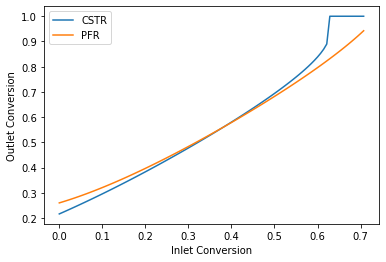

In [28]:
fig, ax = plt.subplots()
ax.plot(x, CSTR)
ax.plot(x, PFR)
ax.legend(["CSTR", "PFR", "CHOICE"])
ax.set_xlabel("Inlet Conversion")
ax.set_ylabel("Outlet Conversion")
line, = ax.plot([], [], '--go', lw=2)

In [29]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [30]:
def animate(i):
    line.set_data(x_sim[0:i+1], choice[0:i+1])
    return (line,)

In [31]:
rc('animation', html='html5')

In [32]:
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(x_sim), interval = 1000, blit = True)

In [33]:
anim.save('PFRCSTRconversion.gif', writer='imagemagick', fps=1)
Image(url='PFRCSTRconversion.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


In [34]:
"""
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'))
anim.save("PFRorCSTR_conversion.mp4", writer = writer)
#HTML(anim.to_html5_video())
"""

'\nWriter = animation.writers[\'ffmpeg\']\nwriter = Writer(fps=1, metadata=dict(artist=\'Me\'))\nanim.save("PFRorCSTR_conversion.mp4", writer = writer)\n#HTML(anim.to_html5_video())\n'

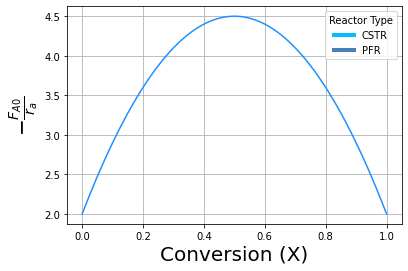

In [35]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
fig, ax = plt.subplots()
ax.plot(X, Y, color = "dodgerblue")
ax.set_xlabel("Conversion (X)", fontsize=label_size)
ax.set_ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
ax.grid(True)


legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='CSTR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='PFR')] 

ax.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
fills = [ax.fill_between([], [])]

In [36]:
def livenspiel_plotter(conversion_in, conversion_out, choice, X_data, Y_data, ax):
    index_in = np.where(abs(X_data - conversion_in) == min(abs(X_data - conversion_in)))[0][0]
    index_out = np.where(abs(X_data - conversion_out) == min(abs(X_data - conversion_out)))[0][0]
    x = X_data[index_in:index_out]
    if choice == 0: # CSTR
        y = np.zeros(x.shape) + Y_data[index_out]
        fill = ax.fill_between(x, y, color = "deepskyblue")
        
    if choice == 1: # PFR
        y = Y_data[index_in:index_out]
        fill = ax.fill_between(x, y, color = "steelblue")
    
    fills.append(fill)    
    return fills

In [37]:
def animate(i):
    fills = livenspiel_plotter(env.X[i], env.X[i+1], env.reactor_seq[i], X, Y, ax)
    return fills

In [38]:
livenspiel_anim = animation.FuncAnimation(fig, animate, frames = len(env.X)-1, interval = 1000, blit = True)

In [39]:
livenspiel_anim.save('Livenspiel.gif', writer='imagemagick', fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


In [40]:
Image(url='Livenspiel.gif')

In [41]:
import pydot
from IPython.display import Image, display
import imageio

In [42]:
reactor_type = ["CSTR", "PFR"]
shapes = ["square", "rectangle"]
G = pydot.Dot(graph_type="digraph", rankdir = "LR", size = "20, 4!")
nodes = []
edges = []
image_list = []

In [43]:
matplotlib.rcParams['figure.dpi']= 400

In [44]:
for i in range(len(env.X)-1):
    r_type = reactor_type[env.reactor_seq[i]]
    Xin = round(env.X[i],2)
    Xout = round(env.X[i + 1],2)
    nodes.append(pydot.Node(f'{i+1} \n {r_type} \n Xin {Xin} \n Xout {Xout}', 
                            height = 2, shape = shapes[env.reactor_seq[i]], fixed_size = True))
    G.add_node(nodes[i])
    if i > 0:
        edges.append(pydot.Edge(nodes[i-1], nodes[i]))
        G.add_edge(edges[i-1])
    BFD = imageio.imread(G.create_png()) # converts to np array
    image_list.append(BFD)

In [45]:
BFD.shape, image_list[0].shape

((384, 1405, 4), (384, 212, 4))

(0.0, 20.0, 0.0, 1.0)

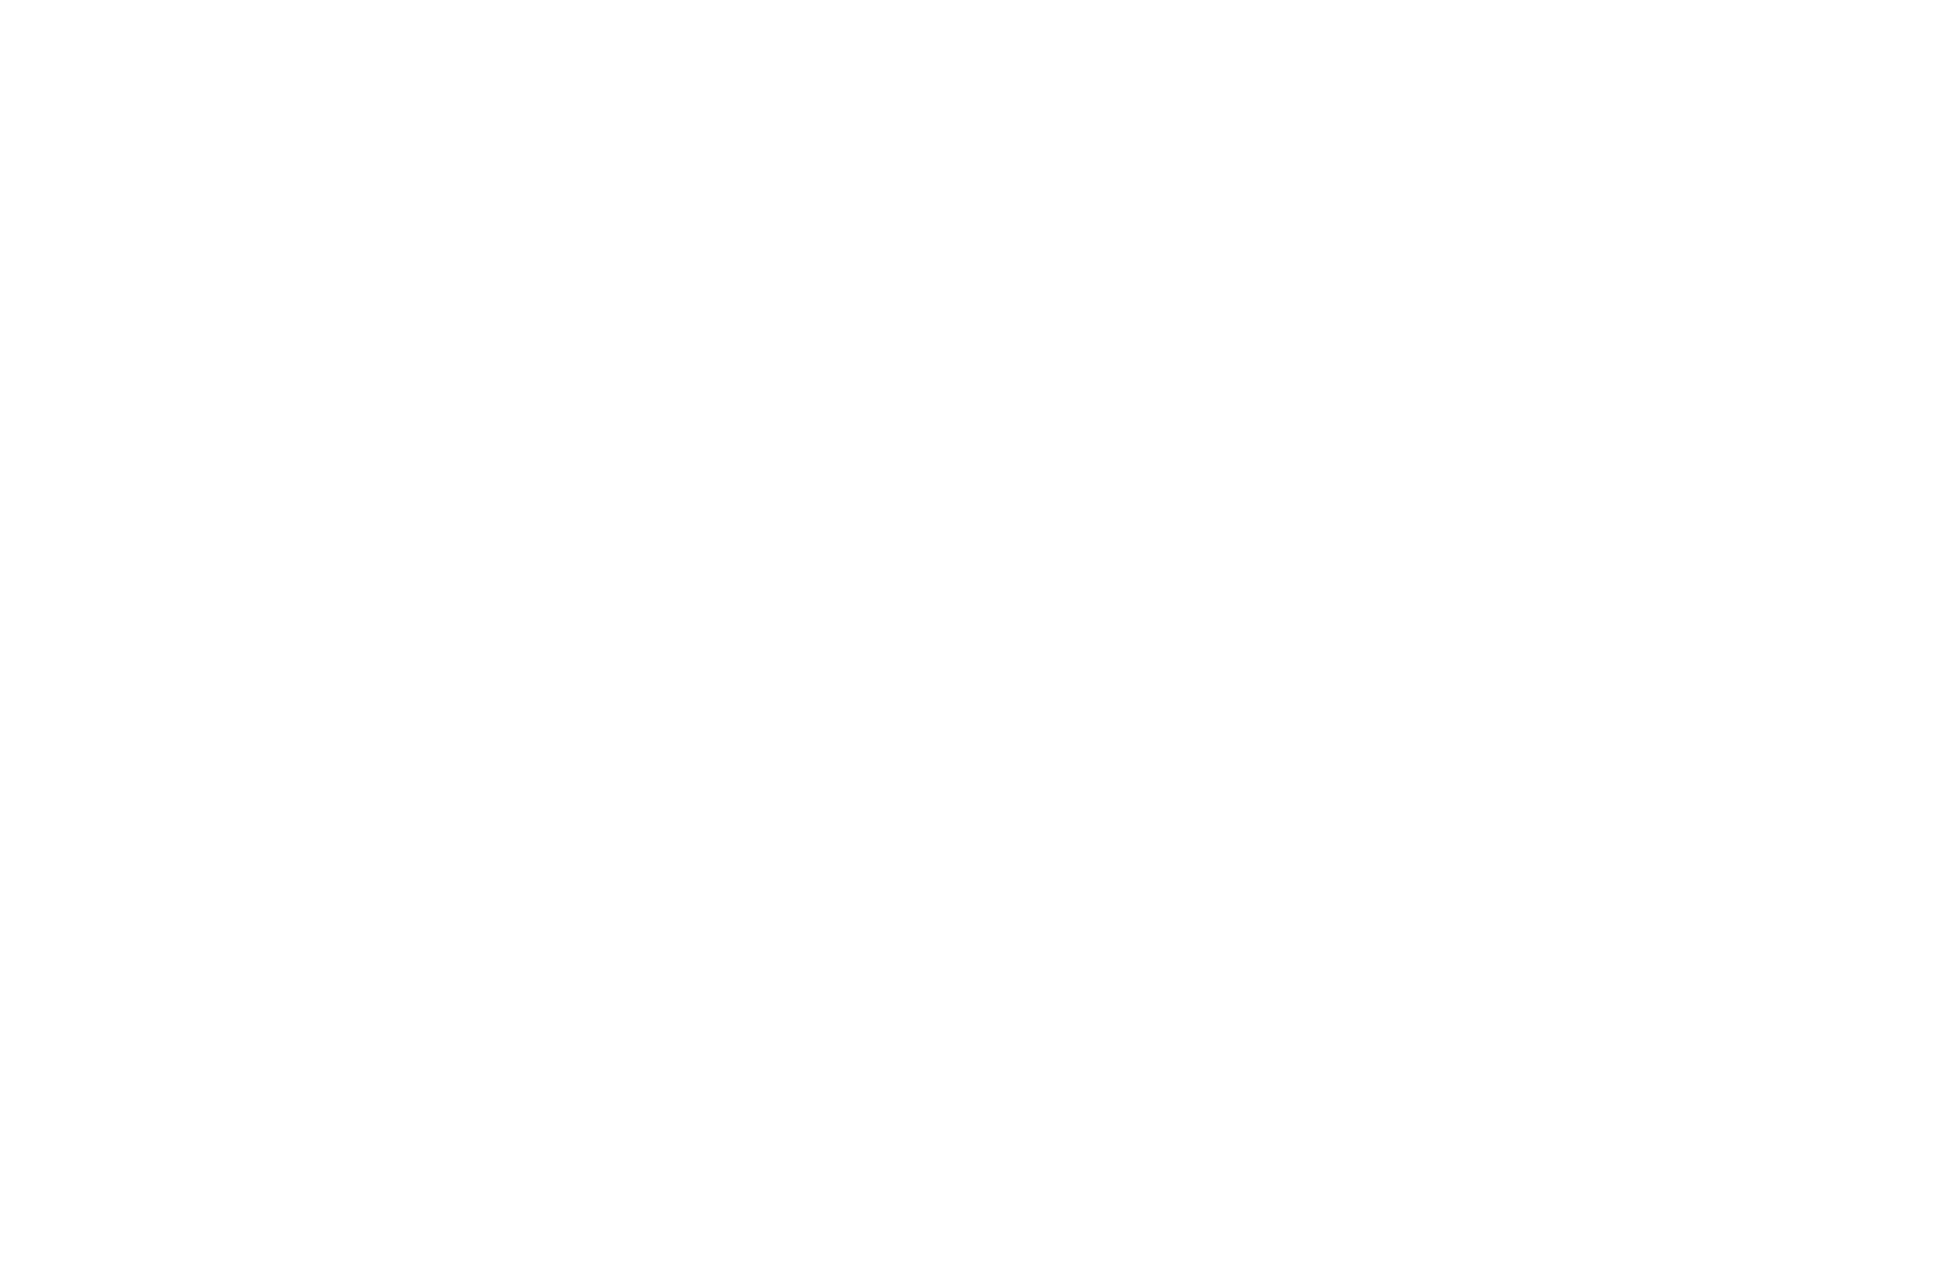

In [46]:
max_width = 20
fig, ax = plt.subplots()
ax.set_xlim(0,max_width)
ax.axis('off')

In [47]:
images = []
final_image_width = image_list[-1].shape[1]
for i in range(len(env.X)-1):
    image_width = image_list[i].shape[1]
    image = ax.imshow(image_list[i], extent = [0, max_width*image_width/final_image_width, 0, 4])
    images.append([image])

In [48]:
animation_BFD = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_BFD.save('BFD.gif', writer='imagemagick', fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


In [49]:
Image(url='BFD.gif')

In [50]:
"""If you want to save single image
with open("reactor_sequence/BFD.png", "wb") as png:
    png.write(G.create_png())
"""
# imageio.mimsave('reactor_sequence/BFD.gif', image_list) tried to to gif but didn't work because of scaling

'If you want to save single image\nwith open("reactor_sequence/BFD.png", "wb") as png:\n    png.write(G.create_png())\n'

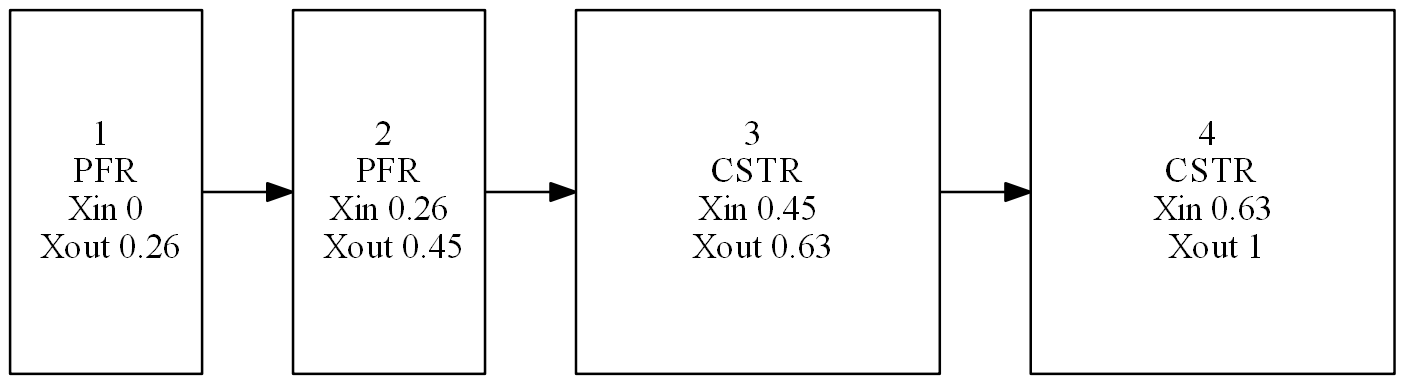

In [51]:
import PIL.Image
import IPython.display
IPython.display.display(PIL.Image.fromarray(image_list[-1]))

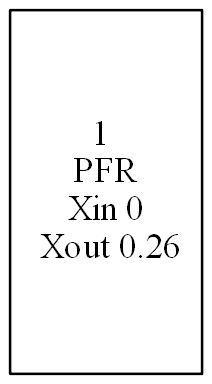

In [52]:
IPython.display.display(PIL.Image.fromarray(image_list[0]))